In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.utils as utils

# Importing Data

In [2]:
import tensorflow_datasets as tfds
train_ds, test_ds = tfds.load('BinaryAlphaDigits',
                              split=['train[:80%]', 'train[80%:]'])

In [3]:
def dataset_to_numpy_images_only(ds):
    images = []
    for item in tfds.as_numpy(ds):
        image = item['image']
        images.append(image)
    return np.array(images)

# Convert datasets to numpy arrays (images only)
X_train = dataset_to_numpy_images_only(train_ds)
X_test = dataset_to_numpy_images_only(test_ds)


In [4]:
def labels_to_np(ds):
    labels = []
    for item in tfds.as_numpy(ds):
        label = item['label']
        labels.append(label)
    return np.array(labels)

# Convert datasets to numpy arrays (images only)
y_train = labels_to_np(train_ds)
y_test = labels_to_np(test_ds)


In [5]:
X_train.shape

(1123, 20, 16, 1)

In [6]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

In [7]:
X_train_tensor.shape

torch.Size([1123, 20, 16, 1])

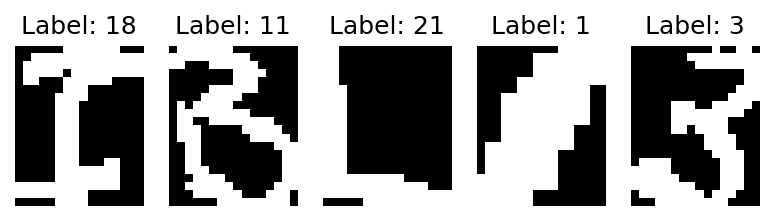

In [8]:
num_images_to_show = 5
random_indices = np.random.randint(0, len(X_train), num_images_to_show)
plt.figure(dpi=150)

# Plotting the images
for i, idx in enumerate(random_indices, 1):
    plt.subplot(1, num_images_to_show, i)
    plt.imshow(X_train[idx].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.show()

In [9]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss'])
results

,Model,Accuracy,Loss


# Standard Neural Net

In [10]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
len(np.unique(y_train))

36

In [12]:
net = nn.Sequential(
    OrderedDict([
        ('flatten', nn.Flatten()),
        ('linear1', nn.Linear(320, 800)),
        ('logistic1', nn.Sigmoid()),
        ('linear2', nn.Linear(800, 800)),
        ('logistic2', nn.Sigmoid()),
        ('linear3', nn.Linear(800, 36)),
    ])
)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.5)

train_loss_list1 = list()
train_acc_list1 = list()
valid_loss_list1 = list()
valid_acc_list1 = list()

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=320, out_features=800, bias=True)
  (logistic1): Sigmoid()
  (linear2): Linear(in_features=800, out_features=800, bias=True)
  (logistic2): Sigmoid()
  (linear3): Linear(in_features=800, out_features=36, bias=True)
)


In [13]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_per_process_memory_fraction(0.8, device=device.index)
net.to(device)

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=320, out_features=800, bias=True)
  (logistic1): Sigmoid()
  (linear2): Linear(in_features=800, out_features=800, bias=True)
  (logistic2): Sigmoid()
  (linear3): Linear(in_features=800, out_features=36, bias=True)
)

In [14]:
num_epochs = 500
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)



    train_loss_list1.append(train_loss)
    train_acc_list1.append(train_accuracy)

    if epoch%20==0 or epoch==100:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ')

print('Finished Training')

Epoch 1/500, Train Loss: 3.7734, Train Acc: 0.0187, 
Epoch 21/500, Train Loss: 3.4015, Train Acc: 0.0917, 
Epoch 41/500, Train Loss: 1.6543, Train Acc: 0.5129, 
Epoch 61/500, Train Loss: 1.0260, Train Acc: 0.6910, 
Epoch 81/500, Train Loss: 0.7117, Train Acc: 0.7685, 
Epoch 101/500, Train Loss: 0.5263, Train Acc: 0.8326, 
Epoch 121/500, Train Loss: 0.3856, Train Acc: 0.8878, 
Epoch 141/500, Train Loss: 0.2953, Train Acc: 0.9110, 
Epoch 161/500, Train Loss: 0.2290, Train Acc: 0.9377, 
Epoch 181/500, Train Loss: 0.1783, Train Acc: 0.9510, 
Epoch 201/500, Train Loss: 0.1499, Train Acc: 0.9573, 
Epoch 221/500, Train Loss: 0.1165, Train Acc: 0.9706, 
Epoch 241/500, Train Loss: 0.1055, Train Acc: 0.9671, 
Epoch 261/500, Train Loss: 0.0905, Train Acc: 0.9697, 
Epoch 281/500, Train Loss: 0.0855, Train Acc: 0.9786, 
Epoch 301/500, Train Loss: 0.0718, Train Acc: 0.9742, 
Epoch 321/500, Train Loss: 0.0732, Train Acc: 0.9697, 
Epoch 341/500, Train Loss: 0.0641, Train Acc: 0.9715, 
Epoch 361/500, T

In [15]:
net.eval()
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float()
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')



Test Loss: 1.5023, Test Acc: 0.6228


In [16]:
results_temp = pd.DataFrame(
    [[
        'Standard NN',
        test_accuracy,
        test_loss
    ]],
    columns=['Model', 'Accuracy', 'Loss']
)

results = pd.concat([results, results_temp], ignore_index=True)
results

,Model,Accuracy,Loss
0,Standard NN,0.622776,1.502313
